In [1]:
import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import osmnx as ox
import folium
import scipy

import seaborn as sns
sns.set_theme()


In [ ]:
df = pd.read_csv('../data/connection_graph.csv', header=0, low_memory = False)
df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1, inplace = True)
df = df[df['company'].str.contains('MPK')]
diff = pd.to_datetime(df['arrival_time']) - pd.to_datetime(df['departure_time'])
df['length'] = diff.dt.seconds // 60
df.drop(columns=['departure_time', 'arrival_time'])

df.head()

In [6]:
G = nx.DiGraph()

for _, row in df.iterrows():
    start = row['start_stop']
    end = row['end_stop']
    length = row['length']
    line = row['line']

    if G.has_edge(start, end):
        G[start][end]['count'] += 1
        G[start][end]['length'].append(length)
        G[start][end]['lines'].add(line)
    else:
        G.add_edge(start, end, count=1, length=[length], lines = {line})
    
for u, v, data in G.edges(data=True):
    data['length'] = max(set(data['length']), key=data['length'].count)
    data['lines'] = len(data['lines'])
    
coords = dict(zip(list(G.nodes), [np.array([df[df.start_stop == spot]['start_stop_lat'].mode()[0], df[df.start_stop == spot]['start_stop_lon'].mode()[0]]) for spot in list(G.nodes)]))

In [7]:
# for u, v, data in G.edges(data=True):
#     print(f"{u} -> {v}: Liczba przejazdów: {data['count']}, Modalna długość: {data['length']}, Liczba unikatowych linii: {data['lines']}")

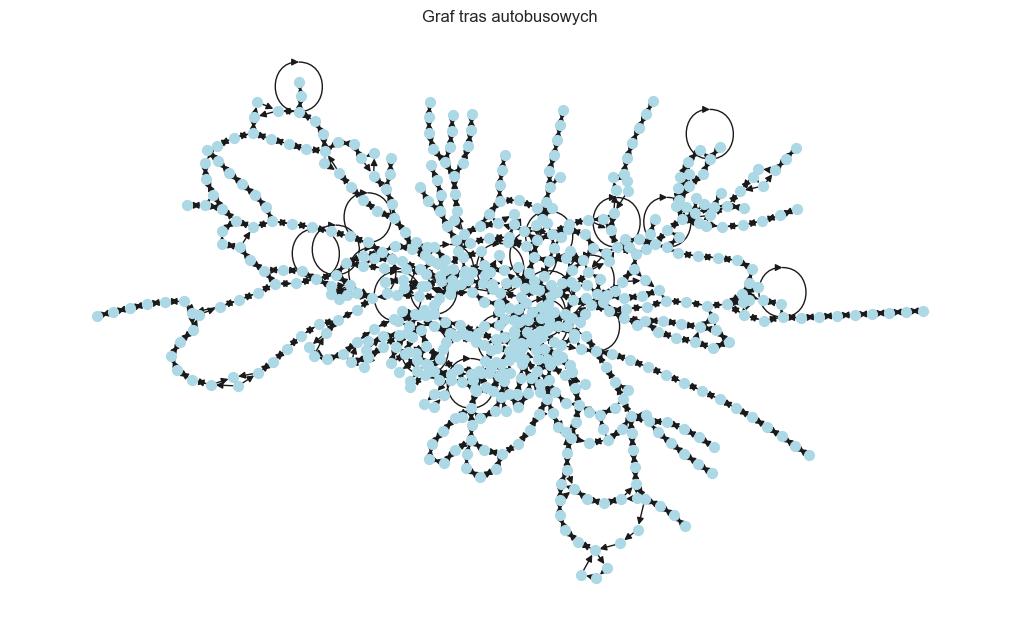

In [8]:
pos = nx.kamada_kawai_layout(G) 
edge_labels = nx.get_edge_attributes(G, 'Weight')  

plt.figure(figsize=(10, 6))
nx.draw(G, pos, node_size=50, node_color='lightblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Graf tras autobusowych")
plt.show()

# Analiza grafu

* najdłuższe trasy (średnica grafu), 
* krytyczność przystanku (przewodnictwo), 
* najważniejsze węzły komunikacyjne - gdzie ludzie się przesiadają (stopień węzła), 
* wykrywanie ciężko dostępnych obszarów (wykrywanie społeczności, modularność), 
* wykrywanie najlepszych lokalizacji (bliskość)  

In [9]:
w_len = nx.get_edge_attributes(G, 'length')
w_line = nx.get_edge_attributes(G, 'lines')
w_count = nx.get_edge_attributes(G, 'count')

**Najdłuższa trasa**

Miara, która pomaga zrozumieć, jak daleko mogą podróżować pasażerowie, aby dotrzeć z jednego punktu sieci do drugiego.

Im większa średnica, tym dłuższe mogą być podróże pasażerów między różnymi obszarami miasta, co może wpływać na czas podróży oraz komfort podróżowania.

In [10]:
nx.diameter(G, weight='length')

76

**Rozkład najkrótszych ścieżek**

Sieci o krótkich ścieżkach i wąskim rozkładzie mogą ułatwiać szybkie podróże między różnymi obszarami, podczas gdy sieci z długimi ścieżkami lub szerokim rozkładem mogą być bardziej wydłużone i mniej efektywne w komunikacji.

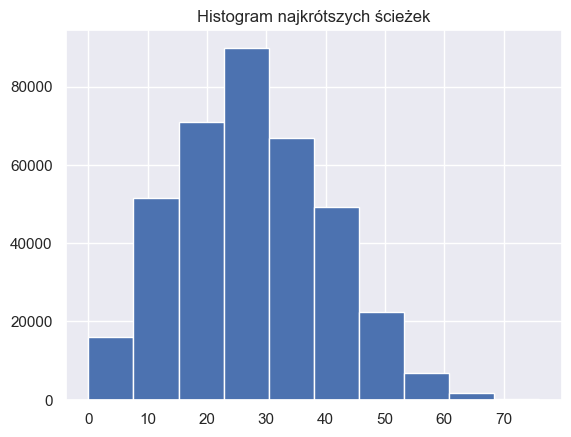

In [11]:
shortest_paths_lengths = []
for source in G.nodes():
    lengths = nx.shortest_path_length(G, source, weight='length')
    shortest_paths_lengths.extend(lengths.values())


plt.hist(shortest_paths_lengths)
plt.title('Histogram najkrótszych ścieżek')
plt.show()

**Krytyczność przystanku**

Przewodnictwo (Betweenness centrality) określa pozycję węzła na podstawie liczby najkrótszych ścieżek przechodzących przez ten węzeł w stosunku do liczby wszystkich najkrótszych ścieżek.

Wierzchołki o wysokiej wartości betweenness centrality są kluczowe dla połączeń między różnymi częściami sieci i mogą mieć duży wpływ na wydajność oraz płynność ruchu.

In [12]:
betweeness = nx.betweenness_centrality(G)
best_betweeness = sorted(betweeness, key=betweeness.get, reverse=True)[:20]


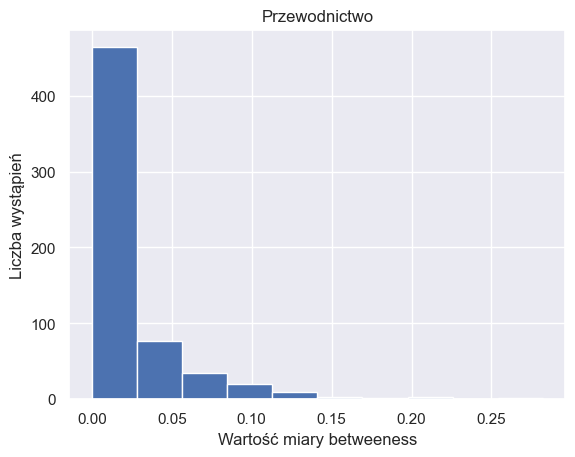

In [13]:
plt.hist(betweeness.values())
plt.title('Przewodnictwo')
plt.xlabel('Wartość miary betweeness')
plt.ylabel('Liczba wystąpień')
plt.show()

**Najważniejsze węzły komunikacyjne**

Przystanki o wysokim stopniu mogą być kluczowe dla obsługi dużej liczby linii autobusowych lub tramwajowych, co może sugerować, że są to ważne węzły transferowe.

In [14]:
degree = list(nx.degree(G, weight='length'))
best_degree = [i[0] for i in sorted(degree, key=lambda x: x[1], reverse=True)[:20]]
degree_val = [x[1] for x in degree]

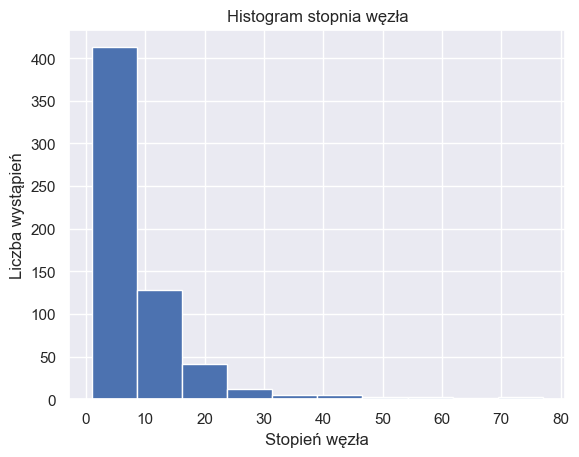

In [15]:
plt.hist(degree_val)
plt.title('Histogram stopnia węzła')
plt.xlabel('Stopień węzła')
plt.ylabel('Liczba wystąpień')
plt.show()


**Wykrywanie najlepszych lokalizacji**

W połączonym grafie bliskość (closeness centrality) to średnia długość najkrótszej ścieżki między węzłem a wszystkimi innymi węzłami w grafie. Im bardziej centralny węzeł, tym znajduje się „bliżej” wszystkich innych węzłów.

In [16]:
closeness = nx.closeness_centrality(G)
best_closeness = sorted(closeness, key=closeness.get, reverse=True)[:20]

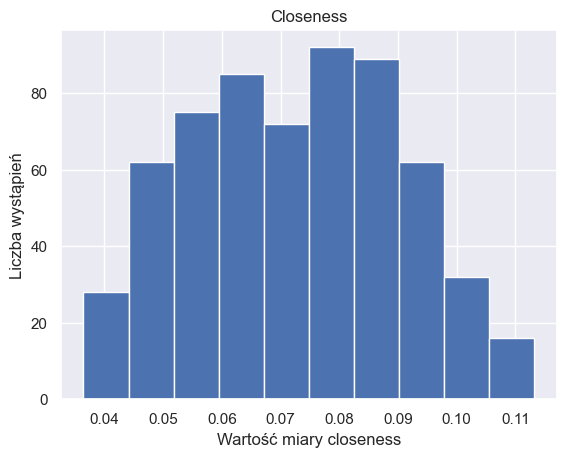

In [17]:
plt.hist(closeness.values())
plt.title('Closeness')
plt.xlabel('Wartość miary closeness')
plt.ylabel('Liczba wystąpień')
plt.show()

**Współczynnik grupowania**

Współczynnik grupowania (Clustering coefficient) mówi nam jak dobrze połączone jest sąsiedztwo danego wierzchołka.

W kontekście sieci przystanków tramwajowych i autobusowych, współczynnik grupowania może pomóc zrozumieć, jak dobrze połączone są sąsiednie przystanki. Wysoki współczynnik grupowania oznacza, że sąsiednie wierzchołki mają tendencję do tworzenia gęstych połączeń, co sugeruje, że istnieją bezpośrednie lub krótkie połączenia między przystankami. Oznacza to, że wierzchołki w grafie, reprezentujące przystanki, tworzą spójne klastry, co może ułatwiać przesiadki pasażerom podróżującym między różnymi liniami lub środkami transportu.

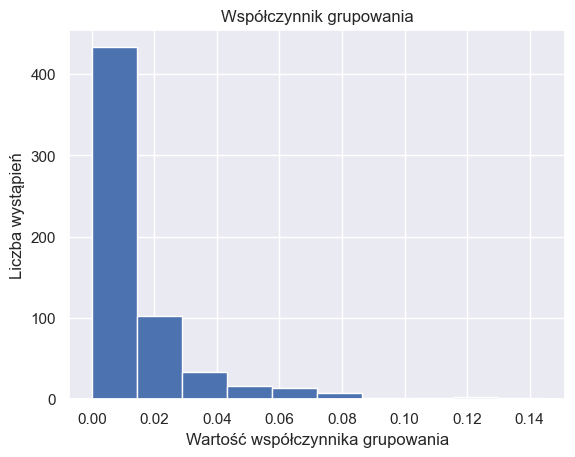

In [18]:
clustering = nx.clustering(G, weight='length')

plt.hist(clustering.values())
plt.title('Współczynnik grupowania')
plt.xlabel('Wartość współczynnika grupowania')
plt.ylabel('Liczba wystąpień')
plt.show()

In [19]:
nx.average_clustering(G)

0.14119591467462336

In [20]:
best_clustering = sorted(clustering, key=clustering.get, reverse=True)[:20]

**PageRank**

PageRank polega na liczeniu liczby i jakości linków do strony (węzła), aby określić przybliżoną ocenę ważności witryny (węzła). Podstawowym założeniem jest to, że im strona jest ważniejsza tym więcej odnośników na nią wskazuje.

In [21]:
pagerank = nx.pagerank(G, weight='length')

best_pagerank = sorted(pagerank, key=pagerank.get, reverse=True)[:20]

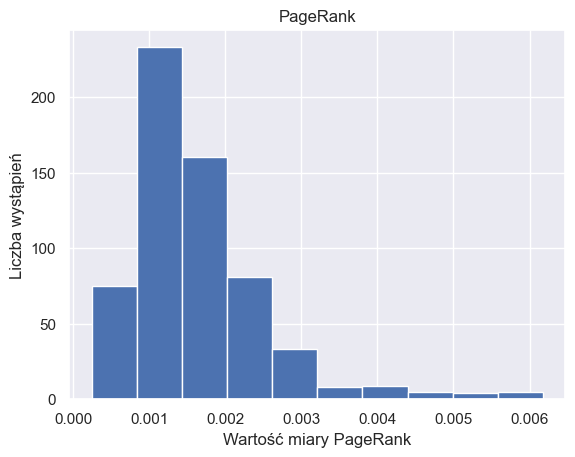

In [22]:
plt.hist(pagerank.values())
plt.title('PageRank')
plt.xlabel('Wartość miary PageRank')
plt.ylabel('Liczba wystąpień')
plt.show()

**Kluczowe przystanki**

z punktu widzenia powyższych miar

In [23]:
df = pd.DataFrame({
    'betweeness': best_betweeness,
    'degree': best_degree,
    'closeness': best_closeness,
    'clustering': best_clustering,
    'pagerank': best_pagerank
})

df

,betweeness,degree,closeness,clustering,pagerank
0,Kwiska,Biskupice Podg. LG Electronics,Rynek,Uniwersytet Wrocławski,FAT
1,GALERIA DOMINIKAŃSKA,GALERIA DOMINIKAŃSKA,PL. JANA PAWŁA II,Reja,GALERIA DOMINIKAŃSKA
2,PL. JANA PAWŁA II,Arkady (Capitol),GALERIA DOMINIKAŃSKA,Bujwida,DWORZEC AUTOBUSOWY
3,Wrocławski Park Technologiczny,Hallera,Dubois,KARŁOWICE,Hallera
4,PL. GRUNWALDZKI,Połabian,Dmowskiego,ROD Oświata,Biskupice Podg. LG Electronics
5,Hallera,Kwiska,Świdnicka,Zajezdnia BOREK,PL. JANA PAWŁA II
6,FAT,Partynice (tor wyścigów konnych),Renoma,Kętrzyńska,PL. GRUNWALDZKI
7,Dubois,DWORZEC AUTOBUSOWY,Hala Targowa,Małopanewska,KROMERA
8,pl. Bema,DWORZEC GŁÓWNY,pl. Orląt Lwowskich,MUCHOBÓR MAŁY (Stacja kolejowa),Wiejska
9,Dmowskiego,KRZYKI,pl. Bema,Sztabowa,Partynice (tor wyścigów konnych)


In [24]:
df2 = df.stack().value_counts().reset_index().rename(columns={'index': 'przystanek'})
df2.head(11)

,przystanek,count
0,GALERIA DOMINIKAŃSKA,4
1,PL. JANA PAWŁA II,4
2,DWORZEC GŁÓWNY,4
3,Dubois,4
4,Kwiska,3
5,Kolista,3
6,FAT,3
7,Arkady (Capitol),3
8,KROMERA,3
9,Hallera,3
